In [1]:
pip install simpy matplotlib


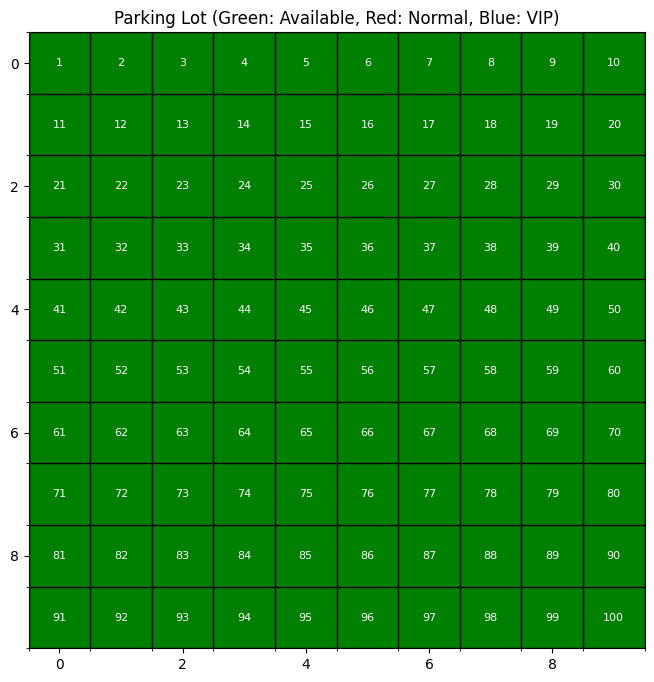


--- Parking Log ---
Car 1 (Normal) in spot 1 at 12:30AM, Day 01
Car 2 (Normal) in spot 2 at 01:00AM, Day 01
Car 3 (Normal) in spot 3 at 01:30AM, Day 01
Car 4 (Normal) in spot 4 at 02:00AM, Day 01
Car 1 (Normal) leaving at 02:02AM, Day 01 estimated time: 1 hours 32 min amount due: $7
Car 5 (Normal) in spot 1 at 02:30AM, Day 01
Car 2 (Normal) leaving at 02:35AM, Day 01 estimated time: 1 hours 35 min amount due: $7
Car 6 (Normal) in spot 2 at 03:00AM, Day 01
Car 7 (Normal) in spot 5 at 03:30AM, Day 01
Car 4 (Normal) leaving at 03:38AM, Day 01 estimated time: 1 hours 38 min amount due: $7
Car 8 (Normal) in spot 4 at 04:00AM, Day 01
Car 3 (Normal) leaving at 04:15AM, Day 01 estimated time: 2 hours 45 min amount due: $8.53
Car 5 (Normal) leaving at 04:25AM, Day 01 estimated time: 1 hours 55 min amount due: $7
Car 9 (Normal) in spot 1 at 04:30AM, Day 01
Car 6 (Normal) leaving at 04:52AM, Day 01 estimated time: 1 hours 52 min amount due: $7
Car 10 (VIP) in spot 81 at 05:00AM, Day 01
Car 11 (N

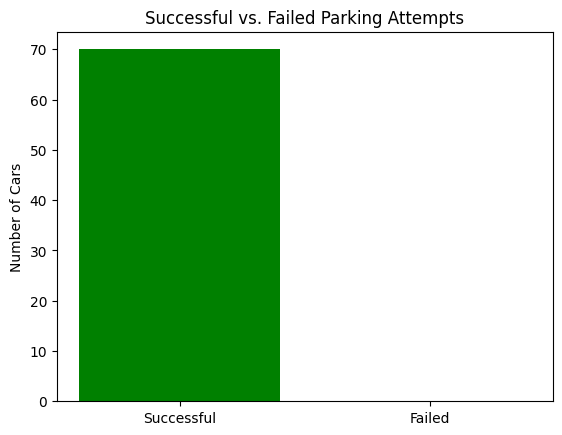

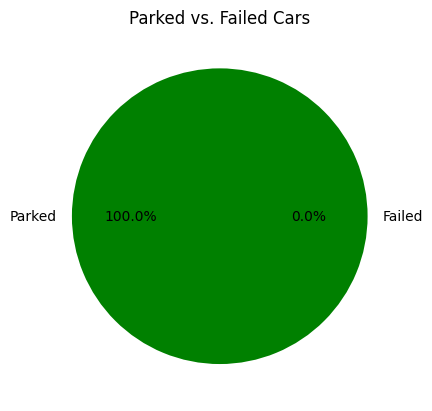

In [4]:
import simpy
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
import numpy as np
from datetime import timedelta, datetime
from IPython.display import clear_output

# Constants
START_TIME = datetime(2023, 1, 1, 0, 0)  # Simulation starts at 12:00 AM, Day 1
VIP_SPOTS = list(range(80, 100))  # VIP parking spots (80–100)
MAX_CARS = 70  # Limit total cars to 70
MAX_VIP_CARS = 15  # At most 15 VIP cars in total

class ParkingLot:
    def __init__(self, env, num_rows, num_cols):
        self.env = env
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.num_spots = num_rows * num_cols
        self.spots = np.full((num_rows, num_cols), None)  # None = empty
        self.total_cars = 0
        self.successful_parks = 0
        self.failed_parks = 0
        self.parking_log = []
        self.car_types = {}  # Map car_id to 'VIP' or 'Normal'

    def park_car(self, car_id, car_type):
        # Find a suitable spot
        spot = None
        if car_type == 'VIP':  # VIP cars park in spots 80–100 only
            for spot_num in VIP_SPOTS:
                row, col = divmod(spot_num, self.num_cols)
                if self.spots[row][col] is None:  # Check if spot is free
                    spot = (row, col, spot_num)
                    break
        else:  # Normal cars park in spots 1–79
            for spot_num in range(self.num_spots):
                if spot_num not in VIP_SPOTS:  # Exclude VIP spots
                    row, col = divmod(spot_num, self.num_cols)
                    if self.spots[row][col] is None:  # Check if spot is free
                        spot = (row, col, spot_num)
                        break

        if spot:  # Spot found
            row, col, spot_num = spot
            self.spots[row][col] = car_id
            self.car_types[car_id] = car_type  # Map the car_id to its type
            self.successful_parks += 1
            self.total_cars += 1

            # Calculate arrival time
            arrival_time = START_TIME + timedelta(hours=self.env.now)
            self.parking_log.append(f"Car {car_id} ({car_type}) in spot {spot_num + 1} at {arrival_time.strftime('%I:%M%p, Day %d')}")

            # Random parking duration: at least 1.5 hours
            park_time = random.uniform(1.5, 3.5)
            yield self.env.timeout(park_time)

            # Departure
            self.spots[row][col] = None
            departure_time = START_TIME + timedelta(hours=self.env.now)
            estimated_time = departure_time - arrival_time

            # Calculate amount due
            if car_type == 'VIP':
                amount_due = round(park_time * 2, 2)  # $2/hour
            else:  # Normal car
                hours = park_time
                if hours <= 1:
                    amount_due = 4
                elif hours <= 2:
                    amount_due = 4 + 3
                else:
                    amount_due = 7 + (hours - 2) * 2
                if hours > 5:
                    amount_due += 30  # Penalty for exceeding 5 hours
                amount_due = round(amount_due, 2)

            self.parking_log.append(
                f"Car {car_id} ({car_type}) leaving at {departure_time.strftime('%I:%M%p, Day %d')} "
                f"estimated time: {int(estimated_time.total_seconds() // 3600)} hours "
                f"{int((estimated_time.total_seconds() % 3600) // 60)} min "
                f"amount due: ${amount_due}"
            )
            self.display_spots()  # Update grid
        else:
            self.failed_parks += 1
            self.parking_log.append(f"Car {car_id} ({car_type}) could not find a spot")

    def display_spots(self):
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(8, 8))
        grid = np.zeros((self.num_rows, self.num_cols))
        for i in range(self.num_rows):
            for j in range(self.num_cols):
                if self.spots[i][j] is not None:
                    car_id = self.spots[i][j]
                    grid[i, j] = 2 if self.car_types[car_id] == 'VIP' else 1

        cmap = colors.ListedColormap(['green', 'red', 'blue'])
        bounds = [0, 0.5, 1.5, 2]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        ax.imshow(grid, cmap=cmap, norm=norm)

        # Add gridlines and spot numbers
        ax.set_xticks(np.arange(-0.5, self.num_cols, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.num_rows, 1), minor=True)
        ax.grid(which="minor", color="black", linestyle="-", linewidth=1)

        for i in range(self.num_rows):
            for j in range(self.num_cols):
                spot_num = i * self.num_cols + j + 1
                ax.text(j, i, str(spot_num), ha="center", va="center", color="white", fontsize=8)

        plt.title("Parking Lot (Green: Available, Red: Normal, Blue: VIP)")
        plt.show()

    def display_parking_log(self):
        print("\n--- Parking Log ---")
        for log in self.parking_log:
            print(log)

    def generate_statistics(self):
        # Bar Chart: Successful vs. Failed Parking Attempts
        plt.figure()
        plt.bar(["Successful", "Failed"], [self.successful_parks, self.failed_parks], color=["green", "red"])
        plt.title("Successful vs. Failed Parking Attempts")
        plt.ylabel("Number of Cars")
        plt.show()

        # Pie Chart: Parked vs. Failed Cars
        plt.figure()
        plt.pie(
            [self.successful_parks, self.failed_parks],
            labels=["Parked", "Failed"],
            autopct="%1.1f%%",
            colors=["green", "red"]
        )
        plt.title("Parked vs. Failed Cars")
        plt.show()



def car_arrival(env, lot, car_id):
    vip_count = 0
    while car_id <= MAX_CARS:
        yield env.timeout(0.5)  # Cars arrive every 0.5 time units
        car_type = 'VIP' if vip_count < MAX_VIP_CARS and random.random() < 0.2 else 'Normal'
        if car_type == 'VIP':
            vip_count += 1
        env.process(lot.park_car(car_id, car_type))
        car_id += 1


# Initialize environment and parking lot
env = simpy.Environment()
num_rows, num_cols = 10, 10  # 10x10 grid for 100 spots
parking_lot = ParkingLot(env, num_rows, num_cols)

# Start car arrivals
env.process(car_arrival(env, parking_lot, car_id=1))

# Run simulation
env.run(until=40)  # Simulate for 40 time units

# Display final parking log
parking_lot.display_parking_log()
parking_lot.generate_statistics()
